In [ ]:
#########
# Setup nur für Google Colab Verbindung zu Google Drive
from google.colab import drive
import os
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/The_Art_of_Sentiment' 

# navigieren zu passendem Verzeichnis
if os.getcwd() != ('/content/' + root_path):
    os.chdir(root_path)

OWD = os.getcwd()

print(os.listdir())

Mounted at /content/gdrive
['.ipynb_checkpoints', 'Composing AI Dataset', 'Kaggle Classical Music Midi', 'erzeugtes', 'models', 'converted_notes.hkl', 'gewichtungen', 'VGMI-Fertiges Skript', 'midi_loader.py', '__pycache__', 'data', 'trained_alr', 'trained', 'text_classifier', 'text_classifier_small']


----

Die Grundlage dieses Projekts ist das [Paper](http://www.lucasnferreira.com/papers/2019/ismir-learning.pdf)
 "Learning to Generate Music with Sentiment"
 von Ferreira, Lucas N. und Whitehead, Jim, das 2019 erschienen ist.

In diesem Paper wird der [VGMIDI Dataset](https://github.com/lucasnfe/vgmidi)
verwendet, der speziell für diesen Zweck erstellt wurde und jeder Midi-Datei eine Emotion zuordnet.

----

In diesem Notebook wird beschrieben, wie ein Neuronales Netzwerk erstellt wird, um neue, negativ- oder positiv-konotierte
Musik erzeugen zu können.



In [ ]:
# Herunterladen des Datensatzes
!wget "https://github.com/lucasnfe/vgmidi/archive/0.1.zip"

# Entpacken 
!unzip 0.1.zip

# The Art of Sentiment: Notebook zum Trainieren des Neuronalen Netzwerks zur Erzeugung von Musik 
Team: Legends


Hier wird das Model auf den nicht-gelabelten Datensatz trainiert.

In [ ]:
# Imports
import os
import json
import numpy as np
import tensorflow as tf

import midi_loader


In [ ]:
# Speicherort der Checkpoints
TRAIN_DIR = "./trained"

In [ ]:
# Codierung
def build_char_to_index(train_vocab, test_vocab):
    # Mergen von Train und Test Vocab
    vocab = list(train_vocab | test_vocab)
    vocab.sort()

    vocab_size = len(vocab)

    # Dictionary zur Codierung
    char_to_index = { char : index for index, char in enumerate(vocab)}

    # Speichern der char_to_index Codierung in einer Json-Datei
    # damit später midi-Dateien erzeugt werden können
    with open(os.path.join(TRAIN_DIR, "char_to_index.json"), "w") as f:
        json.dump(char_to_index, f)
    
    return char_to_index, vocab_size

In [ ]:
def _split_input(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

def build_dataset(text, char_to_index, seq_length, batch_size, buffer_size=10000):
    text_as_int = np.array([char_to_index[c] for c in text.split(" ")])
    char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

    sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

    dataset = sequences.map(_split_input)

    dataset = dataset.shuffle(buffer_size).batch(batch_size, drop_remainder=True)

    return dataset

## Laden des (ungelabelten) Datensatztes

Dazu muss im Ordner 'trained' eine leere Json-Datei mit dem Namen 'char_to_index.json' erstellt werden.

_Anmerkung: Bei erstmaligen Laden des Datensatzes müssen alle Midi-Dateien erst codiert werden. Daher benötigt die nächste Zelle bei erstamliger Ausführung ca. 2 Stunden._

_Wird die Zelle erneut ausgeführt, dann geht dies deutlich schneller, da nur noch die txt-Dateien geladen werden müssen (ca. 1 Minute)_

In [ ]:
# Datensatz wird codiert geladen
# Pfad muss eventuell angepasst werden
train_text, train_vocab = midi_loader.load_midi("./data/vgmidi-0.1/unlabelled/train/")

# Datensatz zum Testen des NN
test_text, test_vocab = midi_loader.load_midi("./data/vgmidi-0.1/unlabelled/test/")

> Parse MIDI-File: ./data/vgmidi-0.1/unlabelled/train/Donkey_Kong_Country_3_JangleBells.mid
> Parse MIDI-File: ./data/vgmidi-0.1/unlabelled/train/Crash_Bandicoot_2_NGin.mid
> Parse MIDI-File: ./data/vgmidi-0.1/unlabelled/train/Terranigma_Sadness.mid
> Parse MIDI-File: ./data/vgmidi-0.1/unlabelled/train/Yoshis_Story_PianoMedley.mid
> Parse MIDI-File: ./data/vgmidi-0.1/unlabelled/train/Sonic_the_Hedgehog_2_Death_Egg_Zone_by_Shazomei.mid
> Parse MIDI-File: ./data/vgmidi-0.1/unlabelled/train/Chrono_Cross_AnotherGuldove.mid
> Parse MIDI-File: ./data/vgmidi-0.1/unlabelled/train/Sims_Building_Theme_6_-_The_Simple_Life_by_Pseudo.mid
> Parse MIDI-File: ./data/vgmidi-0.1/unlabelled/train/Mega_Man_3_PasswordScreen.mid
> Parse MIDI-File: ./data/vgmidi-0.1/unlabelled/train/Street_Fighter_II_Ken_Stage.mid
> Parse MIDI-File: ./data/vgmidi-0.1/unlabelled/train/Chrono_Trigger_600AD.mid
> Parse MIDI-File: ./data/vgmidi-0.1/unlabelled/train/Monkey_Island_1_-_The_Secret_of_Monkey_Island_-_Elaine_Marley_by

In [ ]:
# Dictionary zum Konvertiern von Chars zu Integers
char_to_index, vocab_size = build_char_to_index(train_vocab, test_vocab)

In [ ]:
# Konstanten definieren
SEQ_LEN = 256
BATCH_SIZE = 64

In [ ]:
# Erstelle Datensatz von den codierten ungelabelten Midi-Dateien
train_dataset = build_dataset(train_text, char_to_index, SEQ_LEN, BATCH_SIZE)
test_dataset = build_dataset(test_text, char_to_index, SEQ_LEN, BATCH_SIZE)

## Erstellen des Neuronalen Netzwerks

In [ ]:
# Konstanten des Models

#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
EMB_DIM = 256

# Anzahl der LSTM-Layer
N_LSTM_LAYERS = 4

# Anzahl der Units in einem LSTM-Layer
N_UNTIS = 512

# Vocab_size wird beim Erstellen der Codierung zurückgegeben
VOCAB_SIZE = vocab_size

DROPOUT = 0.05

### Architektur des Models

In [ ]:
def build_model(batch_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(VOCAB_SIZE, EMB_DIM, batch_input_shape=[batch_size, None]))

    # Gegebene Anzahl an LSTM-Layer wird hinzugefügt
    for _ in range(N_LSTM_LAYERS):
        model.add(tf.keras.layers.LSTM(N_UNTIS, stateful=True, return_sequences=True))

    # Fully-Connected Layer mit Vocab-Size als Dimension
    model.add(tf.keras.layers.Dense(vocab_size))

    model.summary()
    return model


In [ ]:
# Build actual model
model = build_model(BATCH_SIZE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           64512     
_________________________________________________________________
lstm (LSTM)                  (64, None, 512)           1574912   
_________________________________________________________________
lstm_1 (LSTM)                (64, None, 512)           2099200   
_________________________________________________________________
lstm_2 (LSTM)                (64, None, 512)           2099200   
_________________________________________________________________
lstm_3 (LSTM)                (64, None, 512)           2099200   
_________________________________________________________________
dense (Dense)                (64, None, 252)           129276    
Total params: 8,066,300
Trainable params: 8,066,300
Non-trainable params: 0
______________________________________________

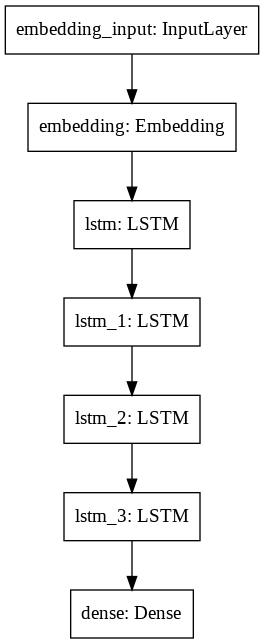

In [ ]:
# Visualisierung des Models
tf.keras.utils.plot_model(model, to_file='model.png')


In [ ]:
# Optional können jetzt noch vorhandene Gewichtungen geladen werden
# Dazu Kommentierung entfernen und "<PATH>" mit dem Pfad der Gewichtungen ersetzen

model.load_weights(tf.train.latest_checkpoint(tf.train.latest_checkpoint("<PATH>")))

### Trainieren des Models

In [ ]:
# Konstanten

LERN_RATE = 0.00001

N_EPOCHS = 15


In [ ]:
# Verlust-Funktion
def generative_loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [ ]:
# Kompilieren des Models
# mit Adam Opitmizer und eigener Velust-Funktion
optimizer = tf.keras.optimizers.Adam(learning_rate=LERN_RATE)
model.compile(optimizer=optimizer, loss=generative_loss)

In [ ]:
# Name der Checkpoints
checkpoint_name = os.path.join(TRAIN_DIR, "unlabelled_checkpoint_{epoch}")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_name, save_weights_only=True)

In [ ]:
# Training wird gestartet
history = model.fit(train_dataset, epochs=N_EPOCHS, validation_data=test_dataset, callbacks=[checkpoint_callback])

Epoch 1/15
   6/4686 [..............................] - ETA: 7:46:54 - loss: 5.5289

## Erzeugen einer Midi-Datei (ohne Gefühlsstimmung)

In [ ]:
import midi_generator

# neues Model mit Batch-Size=1 wird erstellt
generative_model = build_model(1)

# vorhandene Gewichte werden geladen
generative_model.load_weights(tf.train.latest_checkpoint(TRAIN_DIR))

# Input shape anpassen
generative_model.build(tf.TensorShape([1, None]))

# Umkehrung der Codierung: Index zu Char
index_to_char = {index : char for char, index in char_to_index.items()}

####### SEQ
text = midi_generator.generate_midi(model=generative_model, char2idx=char_to_index, idx2char=index_to_char, seq_len=512)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            64512     
_________________________________________________________________
lstm_4 (LSTM)                (1, None, 512)            1574912   
_________________________________________________________________
lstm_5 (LSTM)                (1, None, 512)            2099200   
_________________________________________________________________
lstm_6 (LSTM)                (1, None, 512)            2099200   
_________________________________________________________________
lstm_7 (LSTM)                (1, None, 512)            2099200   
_________________________________________________________________
dense_1 (Dense)              (1, None, 252)            129276    
Total params: 8,066,300
Trainable params: 8,066,300
Non-trainable params: 0
____________________________________________

In [ ]:
midi_loader.write(text, "midi-test.mid")

In [ ]:
print(text)



  n_55 n_42 w_2 w_2 w_2 w_2 w_2 w_2 d_eighth_0 w_2 d_eighth_0 d_eighth_0 w_2 w_2 d_eighth_0 w_2 d_eighth_0 d_eighth_0 w_2 w_2 w_2 d_eighth_0 d_eighth_0 w_2 w_2 d_quarter_0 d_eighth_0 d_quarter_0 d_quarter_0 d_eighth_0 w_2 d_eighth_0 w_2 w_2 d_eighth_0 w_2 w_2 d_eighth_0 d_eighth_0 d_quarter_0 w_2 w_2 d_eighth_0 w_2 d_quarter_0 w_2 d_eighth_0 d_quarter_0 w_2 d_eighth_0 d_eighth_0 d_quarter_0 w_2 w_2 d_eighth_0 d_eighth_0 w_2 w_2 d_eighth_0 d_eighth_0 w_2 d_quarter_0 d_eighth_0 d_eighth_0 w_2 d_quarter_0 d_eighth_0 d_eighth_0 w_2 d_eighth_0 d_eighth_0 w_2 w_2 w_2 w_2 d_quarter_0 w_2 d_eighth_0 w_2 d_eighth_0 d_eighth_0 w_2 d_quarter_0 w_2 w_2 w_2 w_2 w_2 w_2 d_eighth_0 w_2 d_quarter_0 d_eighth_0 w_2 d_quarter_0 d_eighth_0 w_2 d_eighth_0 w_2 d_eighth_0 d_eighth_0 d_quarter_0 w_2 d_quarter_0 d_eighth_0 d_eighth_0 w_2 d_eighth_0 w_2 w_2 w_2 d_quarter_0 w_2 w_2 w_2 d_quarter_0 d_quarter_0 d_eighth_0 d_eighth_0 w_2 d_eighth_0 d_eighth_0 d_eighth_0 w_2 d_eighth_0 d_eighth_0 d_eighth_0 w_2 w_2

## Hinzufügen einer Logistischen Regression für die Erkennung der Gefühlslage

In [ ]:
# Imports
import csv
import pickle

from midi_generator import preprocess_sentence
import graph_plotter
from sklearn.linear_model import LogisticRegression

In [ ]:
def encode_sentence(model, text, char2idx, layer_idx):
    text = preprocess_sentence(text)

    # Zurücksetzen des Models 
    model.reset_states()

    for c in text.split(" "):
        # Hinzufügen der Batch Dimension
        try:
            input_eval = tf.expand_dims([char2idx[c]], 0)
            predictions = model(input_eval)
        except KeyError:
            if c != "":
                print("Can't process char", c)

    h_state, c_state = model.get_layer(index=layer_idx).states

    # Entfernen der Batch Dimension
    c_state = tf.squeeze(c_state, 0)

    return tf.math.tanh(c_state).numpy()

In [ ]:
def build_dataset(datapath, generative_model, char2idx, layer_idx):
    xs, ys = [], []

    # Laden des Datensatzes
    csv_file = open(datapath, "r")
    data = csv.DictReader(csv_file)

    for row in data:
        label = int(row["label"])
        filepath = row["filepath"]

        data_dir = os.path.dirname(datapath)
        phrase_path = os.path.join(data_dir, filepath) + ".mid"
        encoded_path = os.path.join(data_dir, filepath) + ".npy"

        # Laden der Midi-Datei als Text
        if os.path.isfile(encoded_path):
            encoding = np.load(encoded_path)
        else:
            text, vocab = midi_loader.load_midi(phrase_path, transpo_range=1, stretching_range=1)

            # Codieren des Midi texts mit dem Model
            encoding = encode_sentence(generative_model, text, char2idx, layer_idx)

            # Codierung speichern, damit. sie beim nächsten Mal schneller geladen werden kann
            np.save(encoded_path, encoding)

        xs.append(encoding)
        ys.append(label)

    return np.array(xs), np.array(ys)

In [ ]:
def train_classifier_model(train_dataset, test_dataset, C=2**np.arange(-8, 1).astype(np.float), seed=42, penalty="l1"):
    trX, trY = train_dataset
    teX, teY = test_dataset

    scores = []

    # Optimierung der Hyper-parameter 
    for i, c in enumerate(C):
        logreg_model = LogisticRegression(C=c, penalty=penalty, random_state=seed+i, solver="liblinear")
        logreg_model.fit(trX, trY)

        score = logreg_model.score(teX, teY)
        scores.append(score)

    c = C[np.argmax(scores)]

    sent_classfier = LogisticRegression(C=c, penalty=penalty, random_state=seed+len(C), solver="liblinear")
    sent_classfier.fit(trX, trY)

    score =  sent_classfier.score(teX, teY) * 100.

    # Gefühlsklassifizierer wird gespeichert
    with open(os.path.join(TRAIN_DIR, "classifier_ckpt.p"), "wb") as f:
        pickle.dump(sent_classfier, f)

    sentneuron_ixs = get_activated_neurons(sent_classfier)

    # Speichern der resultierenden Gewichtungen (als Graph)
    graph_plotter.plot_weight_contribs(sent_classfier.coef_)
    graph_plotter.plot_logits(trX, trY, sentneuron_ixs)

    return sentneuron_ixs, score

In [ ]:
def get_activated_neurons(sent_classfier):
    neurons_not_zero = len(np.argwhere(sent_classfier.coef_))

    weights = sent_classfier.coef_.T
    weight_penalties = np.squeeze(np.linalg.norm(weights, ord=1, axis=1))

    if neurons_not_zero == 1:
        neuron_ixs = np.array([np.argmax(weight_penalties)])
    elif neurons_not_zero >= np.log(len(weight_penalties)):
        neuron_ixs = np.argsort(weight_penalties)[-neurons_not_zero:][::-1]
    else:
        neuron_ixs = np.argpartition(weight_penalties, -neurons_not_zero)[-neurons_not_zero:]
        neuron_ixs = (neuron_ixs[np.argsort(weight_penalties[neuron_ixs])])[::-1]

    return neuron_ixs

In [ ]:
# Laden der Gewichtungen des Models
generative_model = build_model(1)
generative_model.load_weights(tf.train.latest_checkpoint(TRAIN_DIR))
generative_model.build(tf.TensorShape([1, None]))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (1, None, 256)            64512     
_________________________________________________________________
lstm_8 (LSTM)                (1, None, 512)            1574912   
_________________________________________________________________
lstm_9 (LSTM)                (1, None, 512)            2099200   
_________________________________________________________________
lstm_10 (LSTM)               (1, None, 512)            2099200   
_________________________________________________________________
lstm_11 (LSTM)               (1, None, 512)            2099200   
_________________________________________________________________
dense_2 (Dense)              (1, None, 252)            129276    
Total params: 8,066,300
Trainable params: 8,066,300
Non-trainable params: 0
____________________________________________

_Anmerkung: Auch hier benötigt das erstmalige Laden der Midi-Dateien deutlich mehr Zeit als danach._

In [ ]:
# Erstellen des Datensatzes von den codierten gelabelten Midis
train_dataset = build_dataset("./data/vgmidi-0.1/labelled/vgmidi_sent_train.csv", generative_model, char_to_index, 4)
test_dataset = build_dataset("./data/vgmidi-0.1/labelled/vgmidi_sent_test.csv", generative_model, char_to_index, 4)

> Parse MIDI-File: ./data/vgmidi-0.1/labelled/phrases/BanjoKazooie_BoggysIglooHappy_0.mid
> Parse MIDI-File: ./data/vgmidi-0.1/labelled/phrases/BanjoKazooie_BoggysIglooHappy_1.mid
> Parse MIDI-File: ./data/vgmidi-0.1/labelled/phrases/BanjoKazooie_BoggysIglooHappy_2.mid
> Parse MIDI-File: ./data/vgmidi-0.1/labelled/phrases/BanjoKazooie_BoggysIglooHappy_3.mid
> Parse MIDI-File: ./data/vgmidi-0.1/labelled/phrases/BanjoKazooie_BoggysIglooHappy_4.mid
> Parse MIDI-File: ./data/vgmidi-0.1/labelled/phrases/BanjoKazooie_BoggysIglooSad_0.mid
> Parse MIDI-File: ./data/vgmidi-0.1/labelled/phrases/BanjoKazooie_BoggysIglooSad_1.mid
> Parse MIDI-File: ./data/vgmidi-0.1/labelled/phrases/BanjoKazooie_BoggysIglooSad_2.mid
> Parse MIDI-File: ./data/vgmidi-0.1/labelled/phrases/BanjoKazooie_BoggysIglooSad_3.mid
> Parse MIDI-File: ./data/vgmidi-0.1/labelled/phrases/BanjoKazooie_BubblegloopSwamp_0.mid
> Parse MIDI-File: ./data/vgmidi-0.1/labelled/phrases/BanjoKazooie_BubblegloopSwamp_1.mid
> Parse MIDI-File:

In [ ]:
sentneuron_ixs, score = train_classifier_model(train_dataset, test_dataset)

In [ ]:
print(f"> Anzahl der genutzten Neuronen: {len(sentneuron_ixs)} \n{sentneuron_ixs}")
print(f"Genauigkeit: {score}")

## Start der 'Evolution': Anpassen der Neuronen
Die Neuronen werden nun trainiert, um Musik mit Stimmung erzeugen zu könnnen


_Jetzt werden Methoden zuerst definiert, die später benutzt werden, um die Neuronen zu trainieren, die die gewünschte Stimmung erzeugen sollen._

In [ ]:
# Konstanten
GEN_MIN = -1
GEN_MAX = 1

In [ ]:
def mutation(individual, mutation_rate):
    for i in range(len(individual)):
        if np.random.uniform(0, 1) < mutation_rate:
            individual[i] = np.random.uniform(GEN_MIN, GEN_MAX)

In [ ]:
def crossover(parent_a, parent_b, ind_size):
    # durchschnittliches Crossover
    return (parent_a + parent_b)/2

In [ ]:
def reproduce(mating_pool, new_population_size, ind_size, mutation_rate):
    # Neue 'Population' wird erzeugt
    new_population = np.zeros((new_population_size, ind_size))

    for i in range(new_population_size):
        a = np.random.randint(len(mating_pool))
        b = np.random.randint(len(mating_pool))

        new_population[i] = crossover(mating_pool[a], mating_pool[b], ind_size)

    # Mutation von neuen Kindern
    np.apply_along_axis(mutation, 1, new_population, mutation_rate)

    return new_population

In [ ]:
def roulette_wheel(population, fitness_pop):
    
    norm_fitness_pop = fitness_pop/np.sum(fitness_pop)

    # Zufällige Auswahl
    r = np.random.uniform(0, 1)

    fitness_so_far = 0
    for i in range(len(population)):
        fitness_so_far += norm_fitness_pop[i]

        if r < fitness_so_far:
            return population[i]

    return population[-1]


In [ ]:
def select(population, fitness_pop, mating_pool_size, ind_size, elite_rate):
    mating_pool = np.zeros((mating_pool_size, ind_size))

    # Roulette whell wird aufgerufen, um 'mating_pool_size' indiviuals zu erhalten
    for i in range(mating_pool_size):
        mating_pool[i] = roulette_wheel(population, fitness_pop)

    assert elite_rate >= 0 and elite_rate <= 1
    elite_size = int(np.ceil(elite_rate * len(population)))
    elite_idxs = np.argsort(-fitness_pop)

    for i in range(elite_size):
        r = np.random.randint(0, mating_pool_size)
        mating_pool[r] = elite_idxs[i]

    return mating_pool

In [ ]:
def calc_fitness(individual, gen_model, cls_model, char_to_index, index_to_char, layer_index, sentiment, runs=30):
    encoding_size = gen_model.layers[layer_index].units
    generated_midis = np.zeros((runs, encoding_size))

    # Aktivierung der Neuronen
    sentneuron_ixs = get_activated_neurons(cls_model)
    assert len(individual) == len(sentneuron_ixs)

    # die neuen 'Gene' werden verwendet, um die Neuronen des Models zu überschreiben
    override = {}
    for i, ix in enumerate(sentneuron_ixs):
        override[ix] = individual[i]

    # Erzeugen neuer Stücke und Codieren mit dem Generative Model
    for i in range(runs):
        midi_text = midi_generator.generate_midi(gen_model, char_to_index, index_to_char, seq_len=64, layer_idx=layer_index, override=override)
        generated_midis[i] = encode_sentence(gen_model, midi_text, char_to_index, layer_index)

    midis_sentiment = cls_model.predict(generated_midis).clip(min=0)
    return 1.0 - np.sum(np.abs(midis_sentiment - sentiment))/runs


In [ ]:
def evaluate(population, gen_model, cls_model, char_to_index, index_to_char, layer_index, sentiment):
    fitness = np.zeros((len(population), 1))

    for i in range(len(population)):
        fitness[i] = calc_fitness(population[i], gen_model, cls_model, char_to_index, index_to_char, layer_index, sentiment)

    return fitness

In [ ]:
def evolve(pop_size, ind_size, mut_rate, elite_rate, epochs, generative_model, classifier_model, sentiment):
    # Erschaffen der initialen Population
    print(f"> Erste Population wird gestartet")
    population = np.random.uniform(GEN_MIN, GEN_MAX, (pop_size, ind_size))

    # Bewerten der ersten Population
    fitness_pop = evaluate(population, generative_model, classifier_model, char_to_index, index_to_char, 4, sentiment)
    print(">> Fitness: \n", fitness_pop)

    for i in range(epochs):
        print(f"\n> Epoch {i+1}/{epochs+1} >>")

        # Einzelne Indiviuals werden über das Roulette Wheel ausgewählt
        mating_pool = select(population, fitness_pop, pop_size, ind_size, elite_rate)

        # Crossovers und Mutation erschaffen die neue Population
        population = reproduce(mating_pool, pop_size, ind_size, mut_rate)

        # Jedes Individual wird bewertet
        fitness_pop = evaluate(population, generative_model, classifier_model, char_to_index, index_to_char, 4, sentiment)
        print(">> Fitness: \n", fitness_pop)

    return population, fitness_pop


_Jetzt werden die definierten Methoden benutzt, um die Neuronen zu trainieren, die die gewünschte Stimmung erzeugen sollen._

In [ ]:
# weitere Konstanten
POPULATION_SIZE = 10
EVOLVE_EPOCHS = 10

MUTATION_RATE = 0.1
ELISTM = 0.1

### Starten der Evolution für positive Stimmung

In [ ]:
SENTIMENT = 1
NAME = "positive"
# für negative Gefühlslage -1

In [ ]:
# falls das Verzeichnis der Codierung nicht mehr vorhanden ist
try: (char_to_index)
except NameError:
    with open(os.path.join(TRAIN_DIR, "char_to_index.json"), "w+") as f:
        char_to_index = json.load(f)

In [ ]:
try: (index_to_char)
except NameError:
    index_to_char = {index : char for char, index in char_to_index.items()}

In [ ]:
VOCAB_SIZE = len(char_to_index)

In [ ]:
generative_model_positive = build_model(1)
generative_model_positive.load_weights(tf.train.latest_checkpoint(TRAIN_DIR))
generative_model_positive.build(tf.TensorShape([1, None]))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (1, None, 256)            64512     
_________________________________________________________________
lstm (LSTM)                  (1, None, 512)            1574912   
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 512)            2099200   
_________________________________________________________________
lstm_2 (LSTM)                (1, None, 512)            2099200   
_________________________________________________________________
lstm_3 (LSTM)                (1, None, 512)            2099200   
_________________________________________________________________
dense (Dense)                (1, None, 252)            129276    
Total params: 8,066,300
Trainable params: 8,066,300
Non-trainable params: 0
____________________________________________

In [ ]:
# Laden des Klassifizierungsmodels
with open(os.path.join(TRAIN_DIR, "classifier_ckpt.p"), "rb") as f:
    classifier_model_positive = pickle.load(f)

print(classifier_model_positive)

LogisticRegression(C=0.015625, penalty='l1', random_state=51,
                   solver='liblinear')


In [ ]:
sentneuron_ixs = get_activated_neurons(classifier_model_positive)
index_size = len(sentneuron_ixs)

In [ ]:
population_positive, fitness_pop_positive = evolve(POPULATION_SIZE, index_size, MUTATION_RATE, ELISTM, EVOLVE_EPOCHS, generative_model_positive, classifier_model_positive, sentiment=SENTIMENT)

>> Fitness: 
 [[1.        ]
 [0.86666667]
 [0.96666667]
 [1.        ]
 [0.86666667]
 [0.96666667]
 [0.9       ]
 [0.86666667]
 [1.        ]
 [0.9       ]]
> Epoch 0 >>
>> Fitness: 
 [[0.86666667]
 [0.86666667]
 [0.96666667]
 [0.93333333]
 [0.86666667]
 [0.96666667]
 [0.93333333]
 [0.83333333]
 [0.76666667]
 [0.93333333]]
> Epoch 1 >>
>> Fitness: 
 [[0.86666667]
 [0.93333333]
 [0.9       ]
 [0.93333333]
 [0.96666667]
 [0.83333333]
 [0.93333333]
 [0.83333333]
 [0.96666667]
 [0.96666667]]
> Epoch 2 >>
>> Fitness: 
 [[0.93333333]
 [0.86666667]
 [0.9       ]
 [0.9       ]
 [0.86666667]
 [0.86666667]
 [0.9       ]
 [0.9       ]
 [0.93333333]
 [0.83333333]]
> Epoch 3 >>
>> Fitness: 
 [[0.73333333]
 [0.86666667]
 [0.86666667]
 [0.83333333]
 [0.93333333]
 [0.93333333]
 [0.93333333]
 [0.83333333]
 [0.96666667]
 [0.8       ]]
> Epoch 4 >>
>> Fitness: 
 [[0.9       ]
 [0.83333333]
 [0.9       ]
 [0.86666667]
 [0.76666667]
 [0.9       ]
 [0.76666667]
 [0.93333333]
 [0.83333333]
 [0.93333333]]
> Epo

In [ ]:
# get bestes Individuum
best_index_positive = np.argmax(fitness_pop_positive)
best_individual_positive = population_positive[best_index_positive]

In [ ]:
# Use best individual gens to create a dictionary with cell values
neurons_positive = {}
for i, ix in enumerate(sentneuron_ixs):
    neurons_positive[str(ix)] = best_individual_positive[i]

In [ ]:
print(neurons_positive)

{'466': -0.7949991649771533, '282': -0.0816157120330953, '147': -0.23277896665297285}


In [ ]:
# speichern der positiven Neuronen
with open(os.path.join(TRAIN_DIR, "neurons_"+NAME+".json"), "w") as f:
    json.dump(neurons, f)

### Starten der Evolution für negative Gefühlslage

In [ ]:
SENTIMENT = -1
NAME = "negative"

In [ ]:
generative_model_negative = build_model(1)
generative_model_negative.load_weights(tf.train.latest_checkpoint(TRAIN_DIR))
generative_model_negative.build(tf.TensorShape([1, None]))

In [ ]:
# Laden des Klassifizierungsmodels
with open(os.path.join(TRAIN_DIR, "classifier_ckpt.p"), "rb") as f:
    classifier_model_negative = pickle.load(f)

print(classifier_model_negative)

LogisticRegression(C=0.015625, penalty='l1', random_state=51,
                   solver='liblinear')


In [ ]:
sentneuron_ixs = get_activated_neurons(classifier_model_negative)
index_size = len(sentneuron_ixs)

In [ ]:
population_negative, fitness_pop_negative = evolve(POPULATION_SIZE, index_size, MUTATION_RATE, ELISTM, EVOLVE_EPOCHS, generative_model_negative, classifier_model_negative, sentiment=SENTIMENT)

> Erste Population wird gestartet
>> Fitness: 
 [[-0.93333333]
 [-0.9       ]
 [-0.9       ]
 [-0.93333333]
 [-0.86666667]
 [-0.76666667]
 [-0.8       ]
 [-0.96666667]
 [-0.93333333]
 [-0.86666667]]
> Epoch 0/10 >>
>> Fitness: 
 [[-0.83333333]
 [-0.83333333]
 [-0.86666667]
 [-0.83333333]
 [-0.86666667]
 [-0.96666667]
 [-0.9       ]
 [-0.93333333]
 [-0.83333333]
 [-0.83333333]]
> Epoch 1/10 >>
>> Fitness: 
 [[-0.96666667]
 [-0.9       ]
 [-0.86666667]
 [-0.96666667]
 [-0.8       ]
 [-0.9       ]
 [-0.9       ]
 [-0.86666667]
 [-0.93333333]
 [-1.        ]]
> Epoch 2/10 >>
>> Fitness: 
 [[-0.83333333]
 [-0.9       ]
 [-0.93333333]
 [-0.83333333]
 [-0.83333333]
 [-0.96666667]
 [-0.93333333]
 [-0.93333333]
 [-0.93333333]
 [-0.9       ]]
> Epoch 3/10 >>
>> Fitness: 
 [[-0.93333333]
 [-0.96666667]
 [-0.86666667]
 [-0.93333333]
 [-1.        ]
 [-0.96666667]
 [-0.93333333]
 [-0.86666667]
 [-0.9       ]
 [-0.9       ]]
> Epoch 4/10 >>
>> Fitness: 
 [[-0.86666667]
 [-0.93333333]
 [-0.93333333]
 [

In [ ]:
# get bestes Individuum
best_index_negative = np.argmax(fitness_pop_negative)
best_individual_negative = population_negative[best_index_negative]

In [ ]:
# Use best individual gens to create a dictionary with cell values
neurons_negative = {}
for i, ix in enumerate(sentneuron_ixs):
    neurons_negative[str(ix)] = best_individual_negative[i]

In [ ]:
print(neurons_negative)

In [ ]:
# speichern der positiven Neuronen
with open(os.path.join(TRAIN_DIR, "neurons_"+NAME+".json"), "w") as f:
    json.dump(neurons, f)

## Erzeugen von Musik mit einer Gefühlslage

In [ ]:
# Imports
import os
import json
import numpy as np
import tensorflow as tf
import pickle

import midi_loader
import midi_generator

In [ ]:
# Konstanten beliebig verändern:

# gewünschte Länge des Stücks
DESIRED_SEQ_LEN = 512

# gewünschte Gefühlslage 
# für positive: 1; für negative: -1
DESIRED_SENTIMENT = 1

# Name der Midi-Datei
# hier den ersten String verändern, die Dateiendung (".mid") aber behalten
MIDI_FILE_NAME = "midi-positive" + ".mid"

In [ ]:
def get_neurons(sentiment):
    if sentiment > 0:
        name = "positive"
    else: 
        name = "negative"

    with open(os.path.join(TRAIN_DIR, "neurons_"+name+".json")) as f:
        neurons = json.load(f)

    return neurons

In [ ]:
final_generative_model = build_model(1)
final_generative_model.load_weights(tf.train.latest_checkpoint(TRAIN_DIR))
final_generative_model.build(tf.TensorShape([1, None]))


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (1, None, 256)            64512     
_________________________________________________________________
lstm_16 (LSTM)               (1, None, 512)            1574912   
_________________________________________________________________
lstm_17 (LSTM)               (1, None, 512)            2099200   
_________________________________________________________________
lstm_18 (LSTM)               (1, None, 512)            2099200   
_________________________________________________________________
lstm_19 (LSTM)               (1, None, 512)            2099200   
_________________________________________________________________
dense_4 (Dense)              (1, None, 252)            129276    
Total params: 8,066,300
Trainable params: 8,066,300
Non-trainable params: 0
____________________________________________

In [ ]:
midi_text = midi_generator.generate_midi(final_generative_model, char_to_index, index_to_char, seq_len=512, layer_idx=4, override=get_neurons(DESIRED_SENTIMENT)
)


In [ ]:
print(midi_text)


  t_128 t_128 t_128 t_128 t_113 t_128 
 t_128 t_128 v_108 d_eighth_0 n_35 n_47 w_1 v_124 n_47 w_1 v_92 d_eighth_1 n_40 w_1 d_eighth_0 n_40 w_3 d_16th_0 n_40 w_1 d_eighth_1 n_40 w_4 n_40 w_4 n_40 w_1 
 n_40 w_2 n_40 w_4 d_eighth_0 n_40 w_2 n_40 d_eighth_1 n_64 w_2 d_eighth_0 n_42 w_2 d_eighth_1 n_40 d_16th_0 n_59 w_1 n_59 n_64 w_1 d_eighth_1 n_64 w_1 d_eighth_0 n_42 w_2 n_40 d_16th_0 n_66 w_1 n_64 n_71 w_2 d_quarter_0 n_40 d_16th_0 n_64 w_1 n_64 w_1 n_64 w_2 d_eighth_1 n_64 w_4 d_eighth_0 n_35 d_quarter_0 n_61 n_64 w_2 d_16th_0 n_37 w_1 d_eighth_0 n_61 w_1 d_quarter_0 n_61 w_1 d_eighth_0 n_64 w_1 d_16th_0 n_64 w_1 d_eighth_0 n_37 d_eighth_1 n_64 n_64 w_2 d_eighth_0 n_47 w_2 d_quarter_0 n_37 d_16th_0 n_61 w_1 n_64 w_1 n_61 w_1 d_eighth_1 n_61 w_3 d_16th_0 n_37 n_61 w_2 d_quarter_0 n_37 d_16th_0 n_61 w_2 d_quarter_0 n_37 d_16th_0 n_64 w_1 n_61 w_1 n_61 w_1 d_quarter_0 n_37 d_16th_0 n_61 w_1 n_37 w_2 n_37 w_2 n_37 w_2 d_quarter_0 n_37 d_eighth_0 n_61 w_1 d_quarter_0 n_64 w_2 d_quarter_0 n

In [ ]:
midi_loader.write(midi_text, MIDI_FILE_NAME)

###Musik die im Stück die Stimmung ändert


In [ ]:
midi_text = midi_generator.generate_midi_2_sentiments(final_generative_model, char_to_index, index_to_char, seq_len=1024, layer_idx=4, 
first_override=get_neurons(1), second_override=get_neurons(-1))

In [ ]:
pos_neurons = get_neurons(1)
neg_neurons = get_neurons(-1)

print(pos_neurons, "\n", neg_neurons)

{'466': -0.7949991649771533, '282': -0.0816157120330953, '147': -0.23277896665297285} 
 {'466': 0.15586915277840535, '282': 0.40943974529414623, '147': 0.08178910856027838}


In [ ]:
midi_loader.write(midi_text, "midi_pos_neg.mid")